## K-Nearest Neighbors Classifier for Diabetes Dataset

In [48]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import ydata_profiling
sns.set()
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
# Read the csv file
df = pd.read_csv('diabetes.csv')

In [4]:
# Print first 5 rows
df.head(5)

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [5]:
# Let's explore data with this library
"""
Hear we can see the statistic information about columns, 
 the distribution of columns, corrlation between them and so on. 
"""
profiling = ydata_profiling.ProfileReport(df)
profiling.to_file("profiling.html")
profiling 

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
df_copy = df.copy(deep = True)

In [7]:
# Some columns contain meaningless values (such as 0). To address this issue, we are replacing these values with NaN to facilitate further preprocessing.
df_copy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df_copy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0, np.nan)
print(df_copy.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


### Aiming to impute nan values for the columns in accordance with their distribution

In [8]:
df_copy['Glucose'].fillna(df_copy['Glucose'].mean(), inplace = True)
df_copy['BloodPressure'].fillna(df_copy['BloodPressure'].mean(), inplace = True)
df_copy['SkinThickness'].fillna(df_copy['SkinThickness'].mean(), inplace = True)
df_copy['Insulin'].fillna(df_copy['Insulin'].median(), inplace = True)
df_copy['BMI'].fillna(df_copy['BMI'].mean(), inplace = True)


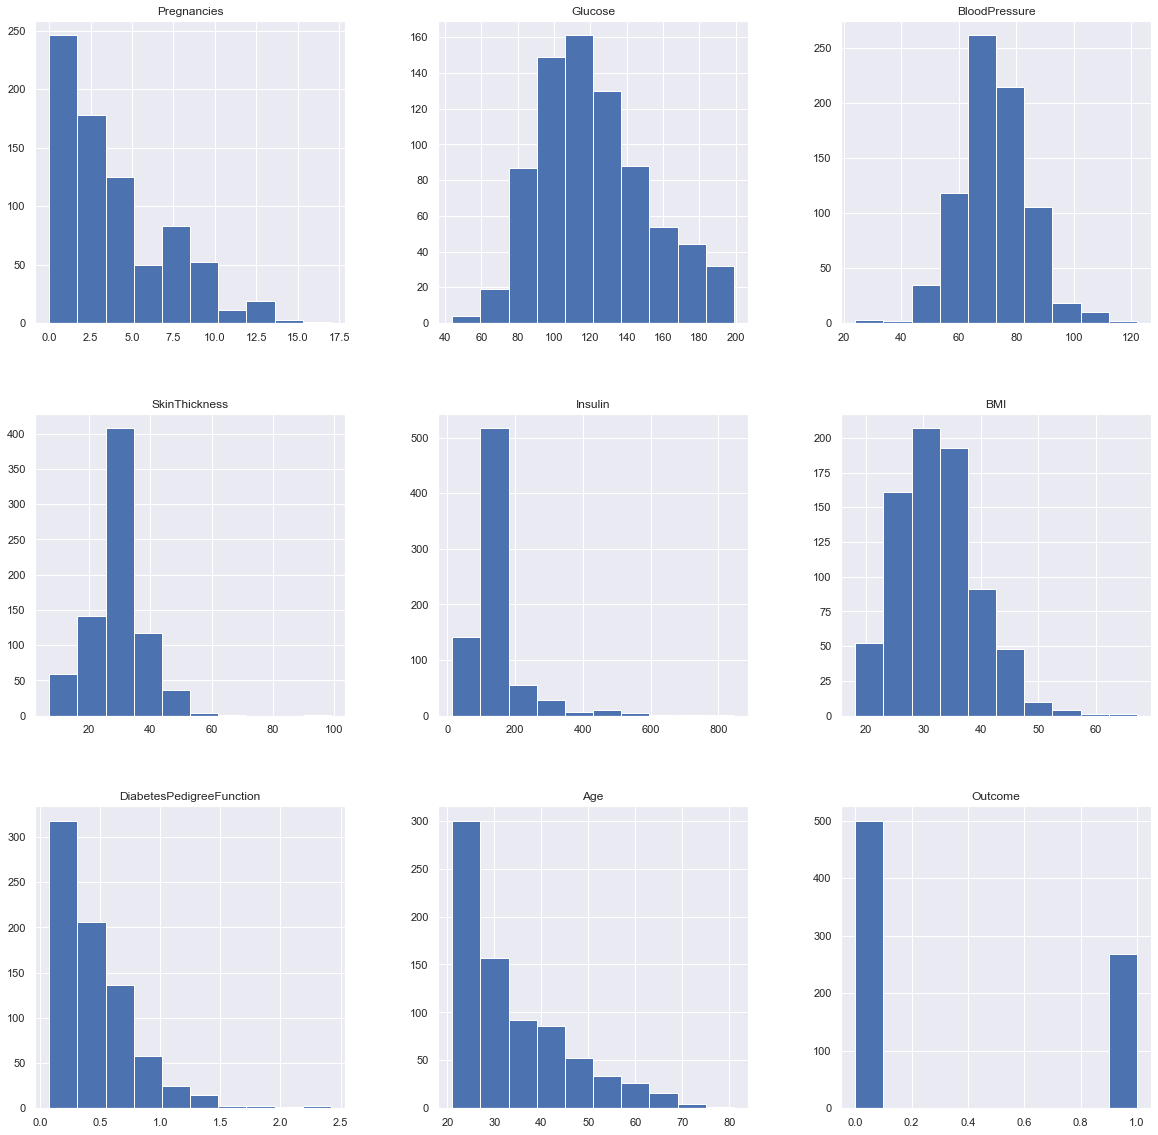

In [9]:
# Display the distribution of columns after filling null values
df_copy.hist(figsize = ( 20,20))
plt.show()

<Figure size 4000x4000 with 0 Axes>

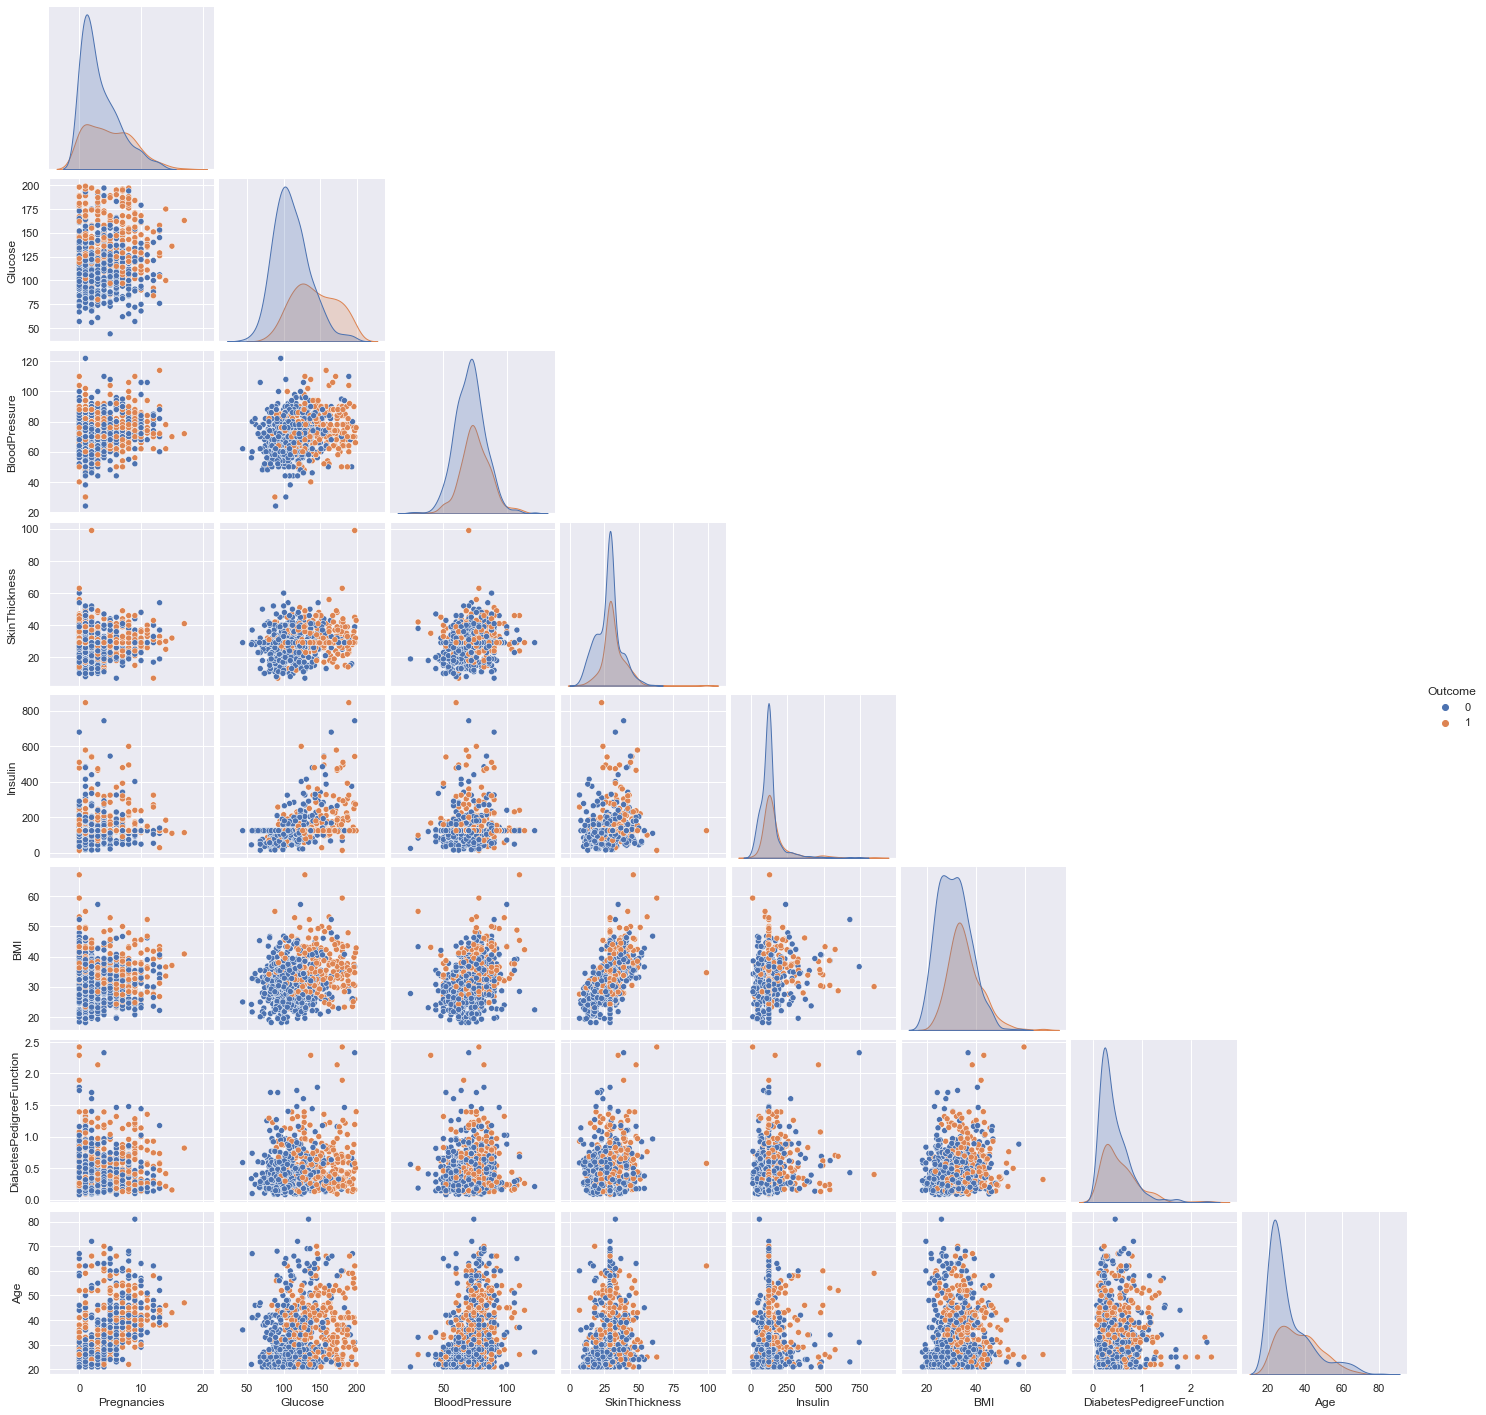

In [10]:
# Display the columns with the pairplot
plt.figure(figsize = ( 20,20), dpi = 200)
p=sns.pairplot(df_copy, hue = 'Outcome',corner=True)

<AxesSubplot:>

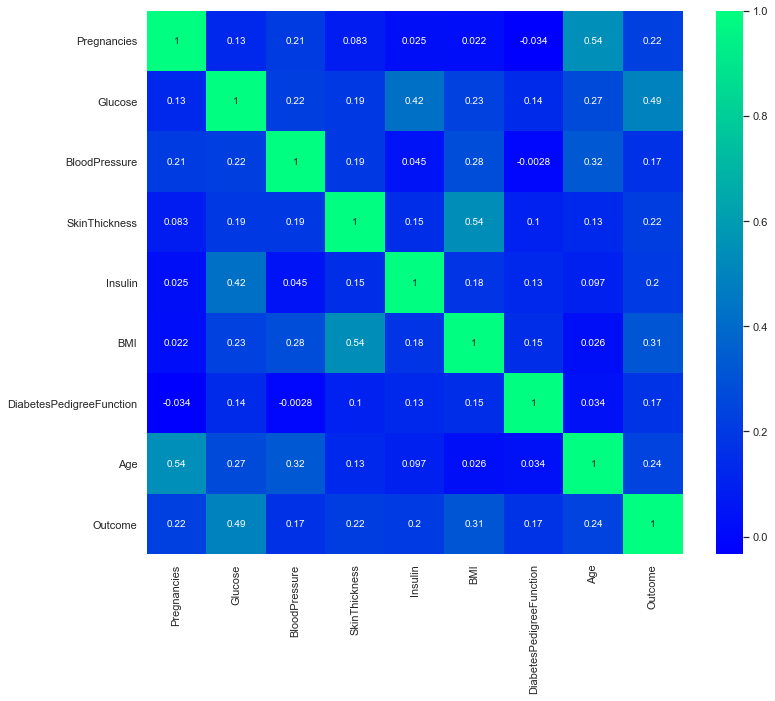

In [11]:
# Correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(df_copy.corr(), annot = True, cmap = 'winter')

### Why Scaling the data for KNN?

#### it is always advisable to bring all the features to the same scale for applying distance based algorithms like KNN.

In [12]:
# Scaling the data for better performance
cols = [col for col in df_copy.columns if col != 'Outcome']
std_scaler = StandardScaler()
Scaled_data = pd.DataFrame(std_scaler.fit_transform(df_copy.drop(["Outcome"],axis = 1),),
        columns = cols)



In [13]:
Scaled_data.head(5)

Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0     0.639947  0.865108      -0.033518   6.655021e-01 -0.181541  0.166292   
1    -0.844885 -1.206162      -0.529859  -1.746338e-02 -0.181541 -0.852531   
2     1.233880  2.015813      -0.695306   8.087936e-16 -0.181541 -1.332833   
3    -0.844885 -1.074652      -0.529859  -7.004289e-01 -0.540642 -0.634212   
4    -1.141852  0.503458      -2.680669   6.655021e-01  0.316566  1.548980   

   DiabetesPedigreeFunction       Age  
0                  0.468492  1.425995  
1                 -0.365061 -0.190672  
2                  0.604397 -0.105584  
3                 -0.920763 -1.041549  
4                  5.484909 -0.020496

In [14]:
y = df_copy.Outcome

## Test Train Split and Cross Validation methods

***Train Test Split*** : To have unknown datapoints to test the data rather than testing with the same points with which the model was trained. This helps capture the model performance much better.

***Cross Validation***: When model is split into training and testing it can be possible that specific type of data point may go entirely into either training or testing portion. This would lead the model to perform poorly. Hence over-fitting and underfitting problems can be well avoided with cross validation techniques

***About Stratify*** : Stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify.

For example, if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.

In [16]:
# split the train and test data

X_train, X_test, y_train, y_test  = train_test_split(Scaled_data ,y, test_size = 0.25,random_state=42,stratify = y)

In [33]:
%%time
test_score = []
train_score = []

for i in range(1,15):
    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train)
    
    train_score.append(knn.score(X_train,y_train))
    test_score.append(knn.score(X_test, y_test))

Wall time: 447 ms


In [34]:
## score that comes from testing on the same datapoints that were used for training
max_train_score = max(train_score)
idn = [i for i,v in enumerate(train_score) if v == max(train_score) ]
print('Max train score {} % and k = {}'.format(max_train_score *100, list(map(lambda x: x + 1, idn))))

Max train score 100.0 % and k = [1]


In [35]:
## score that comes from testing on the same datapoints that were used for training
max_test_score = max(test_score)
idn = [i for i,v in enumerate(test_score) if v == max(test_score) ]
print('Max train score {} % and k = {}'.format(max_test_score *100, list(map(lambda x: x + 1, idn))))

Max train score 74.47916666666666 % and k = [5]


## Result Visualisation

<AxesSubplot:>

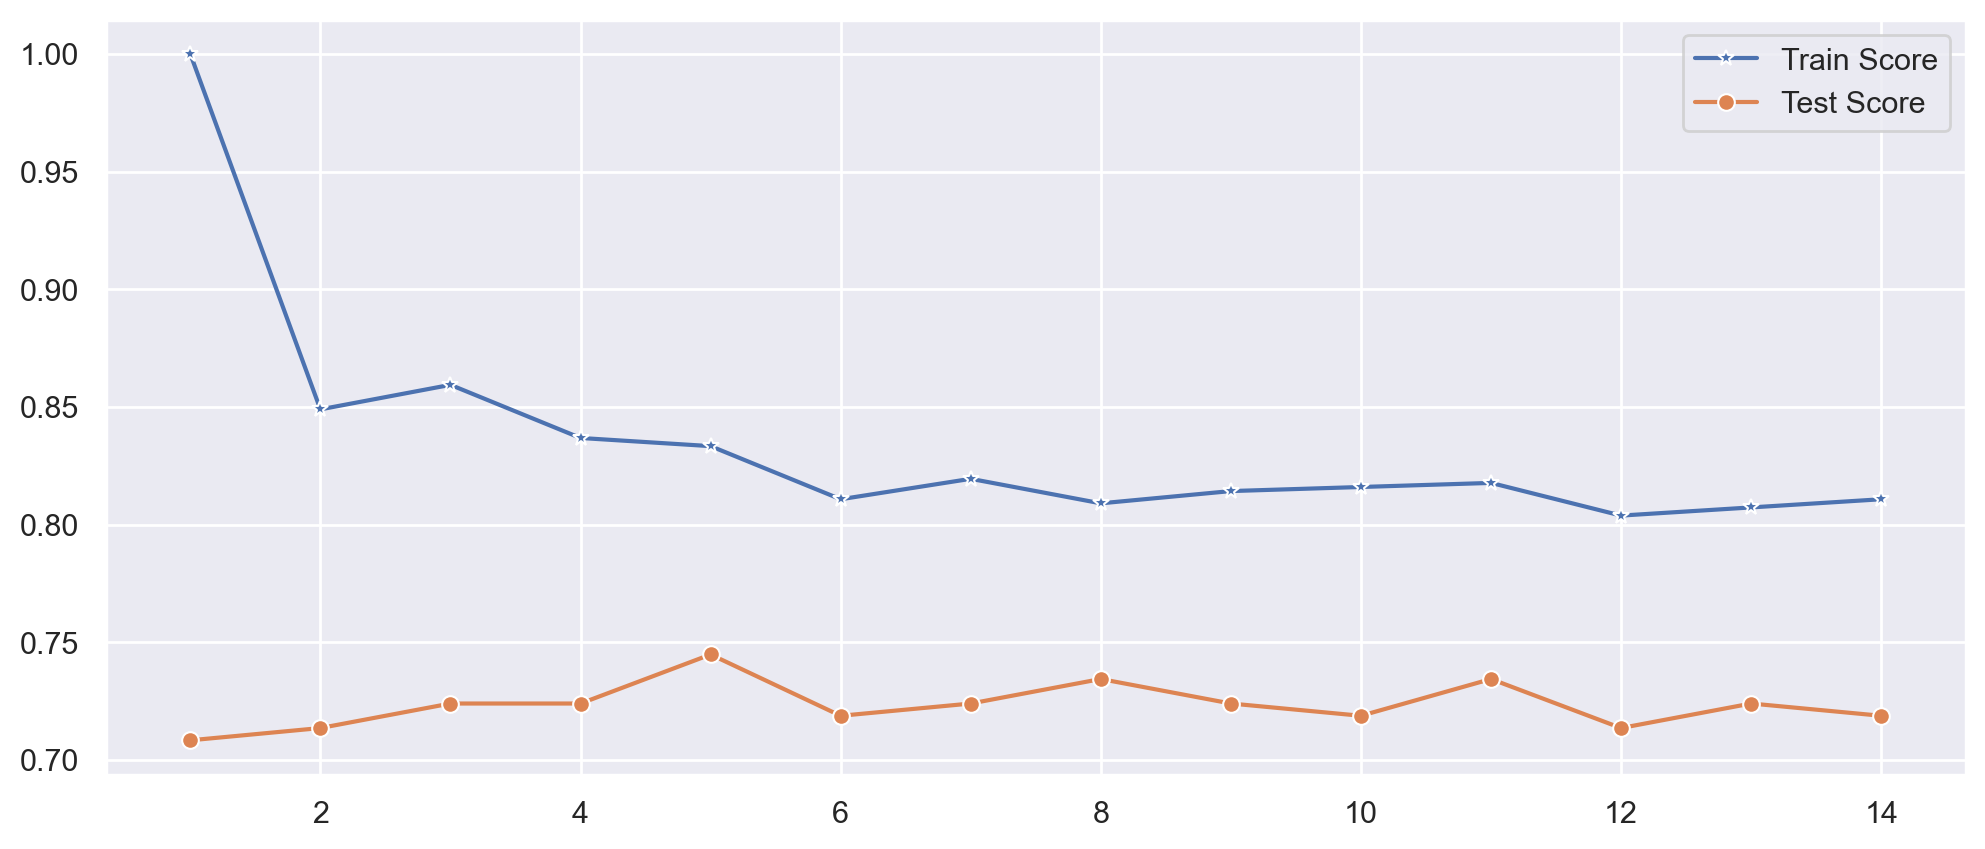

In [37]:
plt.figure(figsize=(12,5), dpi = 200)

sns.lineplot(range(1,15), train_score, marker = '*', label = 'Train Score')
sns.lineplot(range(1,15), test_score, marker = 'o', label = 'Test Score')

#### The best result is captured at k = 5 hence 5 is used for the final model

In [38]:
#Setup a knn classifier with k neighbors

knn = KNeighborsClassifier(5)

knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.7447916666666666

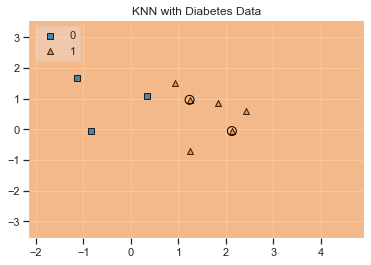

In [40]:
# plot_decision_regions function to visualize the decision regions of a KNN classifier.
value = 20000
width = 20000
plot_decision_regions(Scaled_data.values, y.values, clf=knn, legend=2, 
                      filler_feature_values={2: value, 3: value, 4: value, 5: value, 6: value, 7: value},
                      filler_feature_ranges={2: width, 3: width, 4: width, 5: width, 6: width, 7: width},
                      X_highlight=X_test.values)


plt.title('KNN with Diabetes Data')
plt.show()

# Model Performance Analysis

## 1. Confusion Matrix

The confusion matrix is a technique used for summarizing the performance of a classification algorithm i.e. it has binary outputs.

In [45]:
y_pred = knn.predict(X_test)
confusion_matrix(y_test,y_pred)
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted    0   1  All
True                   
0          105  20  125
1           29  38   67
All        134  58  192

Text(0.5, 12.5, 'Predicted label')

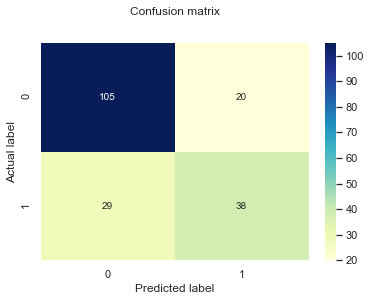

In [46]:
y_pred = knn.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## 2. Classification Report

Report which includes Precision, Recall and F1-Score.


#### Precision Score
        TP – True Positives
        FP – False Positives

        Precision – Accuracy of positive predictions.
        Precision = TP/(TP + FP)
        
   
#### Recall Score
        FN – False Negatives

        Recall(sensitivity or true positive rate): Fraction of positives that were correctly identified.
        Recall = TP/(TP+FN)
        
#### F1 Score
        F1 Score (aka F-Score or F-Measure) – A helpful metric for comparing two classifiers.
        F1 Score takes into account precision and the recall. 
        It is created by finding the the harmonic mean of precision and recall.

        F1 = 2 x (precision x recall)/(precision + recall)

In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       125
           1       0.66      0.57      0.61        67

    accuracy                           0.74       192
   macro avg       0.72      0.70      0.71       192
weighted avg       0.74      0.74      0.74       192



## 3. ROC - AUC
ROC (Receiver Operating Characteristic) Curve tells us about how good the model can distinguish between two things (e.g If a patient has a disease or no). Better models can accurately distinguish between the two. Whereas, a poor model will have difficulties in distinguishing between the two

In [52]:
y_pred_proba = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

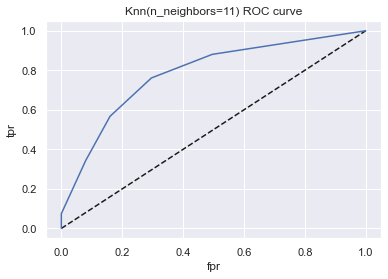

In [53]:
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=11) ROC curve')
plt.show()

In [55]:
roc_auc_score(y_test,y_pred_proba)

0.7815522388059701

# Hyper Parameter optimization
Grid search is an approach to hyperparameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid. 

In [57]:
%%time

param_grid = {'n_neighbors':np.arange(1,20)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv = 5) 

knn_cv.fit(Scaled_data,y)

print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

Best Score:0.7695696460402341
Best Parameters: {'n_neighbors': 16}
Wall time: 3.81 s
